In [1]:
!pip install datasets transformers
!pip install git-lfs
!pip install optuna
!pip install ray[tune]



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 2.7 MB/s 
     |████████████████████████████████| 4.9 MB 46.0 MB/s 
     |████████████████████████████████| 120 kB 55.9 MB/s 
     |████████████████████████████████| 115 kB 55.0 MB/s 
     |████████████████████████████████| 212 kB 55.6 MB/s 
     |████████████████████████████████| 127 kB 45.9 MB/s 
     |████████████████████████████████| 6.6 MB 43.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 2.6 MB/s 
     |████████████████████████████████| 81 kB 6.8 MB/s 
     |████████████████████

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
import datasets
import random
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch
from torch.nn.functional import cross_entropy


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [4]:
def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True, padding=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True,padding=True)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    if task != "stsb":
        predictions = np.argmax(predictions, axis=1)
    else:
        predictions = predictions[:, 0]
    return metric.compute(predictions=predictions, references=labels)

def model_init():
  return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

def label_int2str(row):
    return dataset["train"].features["label"].int2str(row)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"],
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [5]:
task = "sst2"
model_checkpoint = "bert-base-uncased"
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
actual_task = "mnli" if task == "mnli-mm" else task
dataset = load_dataset("glue", actual_task)
metric = load_metric('glue', actual_task)
num_labels = 3 if task.startswith("mnli") else 1 if task=="stsb" else 2

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast = True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

sentence1_key, sentence2_key = task_to_keys[task]
encoded_dataset = dataset.map(preprocess_function, batched=True)

metric_name = "pearson" if task == "stsb" else "matthews_correlation" if task == "cola" else "accuracy"
model_name = model_checkpoint.split("/")[-1]
logging_steps = len(encoded_dataset["train"]) // batch_size

args = TrainingArguments(f"{model_name}-finetuned-{task}",
                         num_train_epochs=1,
                         learning_rate=2e-5,
                         per_device_train_batch_size=batch_size,
                         per_device_eval_batch_size=batch_size,
                         weight_decay=0.01,
                         evaluation_strategy="epoch",
                         save_strategy="epoch",
                         disable_tqdm=False,
                         logging_steps=logging_steps,
                         push_to_hub=True,
                         log_level="error",
                         load_best_model_at_end=True)

validation_key = "validation_mismatched" if task == "mnli-mm" else "validation_matched" if task == "mnli" else "validation"

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset[validation_key],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_dataset = encoded_dataset["train"].shard(index=1, num_shards=10) 

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Cloning https://huggingface.co/albertdestajo/bert-base-uncased-finetuned-sst2 into local empty directory.


In [9]:
dataset["train"].features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=['negative', 'positive'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [10]:
dataset.set_format(type="pandas")
df = dataset["train"][:]
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,sentence,label,label_name
0,hide new secretions from the parental units,0,negative
1,"contains no wit , only labored gags",0,negative
2,that loves its characters and communicates som...,1,positive
3,remains utterly satisfied to remain the same t...,0,negative
4,on the worst revenge-of-the-nerds clichés the ...,0,negative


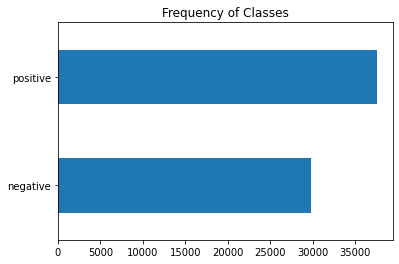

In [11]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [12]:
dataset.reset_format()

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


In [25]:
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Sep27_03-36-29_9df1ebf4ffd5/1664252627.5611362/events.out.tfevents.1664252627.9df1ebf4ffd5.54…

Upload file runs/Sep27_03-36-29_9df1ebf4ffd5/1664255062.6167703/events.out.tfevents.1664255062.9df1ebf4ffd5.54…

Upload file runs/Sep27_03-36-29_9df1ebf4ffd5/events.out.tfevents.1664252627.9df1ebf4ffd5.54.2:  74%|#######4  …

Upload file runs/Sep27_03-36-29_9df1ebf4ffd5/events.out.tfevents.1664255062.9df1ebf4ffd5.54.4:  74%|#######4  …

Upload file runs/Sep27_03-36-29_9df1ebf4ffd5/events.out.tfevents.1664249816.9df1ebf4ffd5.54.0:  76%|#######5  …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/albertdestajo/distilbert-base-uncased-finetuned-mrpc
   f1e2f47..8651ff7  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/albertdestajo/distilbert-base-uncased-finetuned-mrpc
   f1e2f47..8651ff7  main -> main

To https://huggingface.co/albertdestajo/distilbert-base-uncased-finetuned-mrpc
   8651ff7..74ea916  main -> main

   8651ff7..74ea916  main -> main



'https://huggingface.co/albertdestajo/distilbert-base-uncased-finetuned-mrpc/commit/8651ff78194dc52144f0025d74ddea2deab05b69'

In [20]:
preds_output = trainer.predict(encoded_dataset["validation"])

In [21]:
preds_output.metrics

{'test_loss': 0.4502333104610443,
 'test_accuracy': 0.7916666666666666,
 'test_f1': 0.8608837970540099,
 'test_runtime': 55.0746,
 'test_samples_per_second': 7.408,
 'test_steps_per_second': 0.472}

In [22]:
def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [23]:
# Convert our dataset back to PyTorch tensors
encoded_dataset.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
encoded_dataset["validation"] = encoded_dataset["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/26 [00:00<?, ?ba/s]

In [24]:
encoded_dataset.set_format("pandas")
cols = ["sentence", "label", "predicted_label", "loss"]
df_test = encoded_dataset["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))
df_test.sort_values("loss", ascending=True).head(10)

,sentence1,sentence2,label,predicted_label,loss
336,""" Close co-operation between our law enforceme...",Close cooperation between regional law enforce...,equivalent,equivalent,0.058263
351,Judge Craig Doran said it wasn 't his role to ...,Judge Craig Doran said he couldn 't determine ...,equivalent,equivalent,0.059221
331,Hester said Sanmina was the best fit among sev...,Hester said Sanmina 's offer was the best amon...,equivalent,equivalent,0.060342
88,University of Michigan President Mary Sue Cole...,""" Our fundamental values haven 't changed , "" ...",equivalent,equivalent,0.061300
226,""" No matter who becomes the sponsor for stock-...",No matter who becomes the sponsor for stock-ca...,equivalent,equivalent,0.061391
0,He said the foodservice pie business doesn 't ...,""" The foodservice pie business does not fit ou...",equivalent,equivalent,0.061705
381,Officials are also meeting with the Internatio...,Canadian officials were also expected to meet ...,equivalent,equivalent,0.062239
119,"He said : "" For the first time there is an eas...",""" For the first time , there is an easy and af...",equivalent,equivalent,0.062641
39,""" Instead of pursuing the most imminent and re...",""" Instead of pursuing the most imminent and re...",equivalent,equivalent,0.063343
230,The announcement was made during the recording...,The broadside came during the recording on Sat...,equivalent,equivalent,0.064642


Hyperparameter Search

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

Downloading trained model from huggingface hub

In [4]:
from transformers import pipeline

model_id = "distilbert-base-uncased-finetuned-sst-2-english" #will need to update once trainer is done
classifier = pipeline("text-classification", model=model_id)

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [13]:
custom_sentence1 = "I saw a movie today and it was really good."
custom_sentence2 = "I saw a movie today and it was really bad."

results = classifier([custom_sentence1,custom_sentence2])
for result in results:
  print(result)

{'label': 'POSITIVE', 'score': 0.9998685121536255}
{'label': 'NEGATIVE', 'score': 0.9997885823249817}
